In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [3]:
x_train = pd.read_csv("../input/digit-recognizer/train.csv")
x_test = pd.read_csv("../input/digit-recognizer/test.csv")

In [4]:
X = x_train.values

y = X[:, 0]
X = X[:, 1:]


from sklearn.model_selection import train_test_split

train_size=0.8

X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=0.8)

In [5]:
X_valid.shape

(8400, 784)

In [6]:
test = x_test.values
test = test[:, np.newaxis]

X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_valid = X_valid.reshape(len(X_valid), 28, 28, 1)

test = test.reshape(len(test), 28, 28, 1)

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


cnn = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=[28, 28, 1]),
    
    #preprocessing.RandomWidth(factor=0.15),
    #preprocessing.RandomHeight(factor=0.15),
    #preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=3,activation='relu'),
    layers.MaxPool2D(pool_size=2,strides=2, padding='same'),
    

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=3,activation='relu'),
    layers.MaxPool2D(pool_size=2,strides=2, padding='same'),
    
    
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    
    layers.Dropout(0.3),
    layers.Dense(units=128,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=128,activation='relu'),
    layers.Dense(units=10,activation='softmax')
])

2022-10-06 18:01:45.188188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 18:01:45.268063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 18:01:45.268858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 18:01:45.269978: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [9]:
#compiling
cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

2022-10-06 18:01:48.026500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-06 18:01:49.852203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1050/1050 [==============================] - 12s 5ms/step - loss: 0.4759 - accuracy: 0.8730 - val_loss: 0.0800 - val_accuracy: 0.9771
Epoch 2/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1186 - accuracy: 0.9636 - val_loss: 0.0650 - val_accuracy: 0.9811
Epoch 3/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0949 - accuracy: 0.9704 - val_loss: 0.0621 - val_accuracy: 0.9817
Epoch 4/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0836 - accuracy: 0.9744 - val_loss: 0.0490 - val_accuracy: 0.9860
Epoch 5/100
1050/1050 [==============================] - 5s 4ms/step - loss: 0.0713 - accuracy: 0.9774 - val_loss: 0.0475 - val_accuracy: 0.9857
Epoch 6/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0703 - accuracy: 0.9782 - val_loss: 0.0441 - val_accuracy: 0.9865
Epoch 7/100
1050/1050 [==============================] - 5s 4ms/step - loss: 0.0581 - accuracy: 0.9827 - val_loss: 0.0440 - val_accuracy: 0.9

<AxesSubplot:>

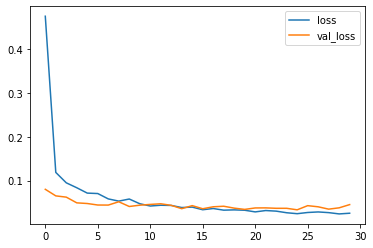

In [10]:
#training
history = cnn.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    callbacks=[early_stopping],
    epochs=100)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()

In [11]:
predictions = cnn.predict(test)

In [12]:
pred_lab = np.argmax(predictions, axis=-1)
pred_lab.reshape(28000, 1)

pred_df = pd.DataFrame(pred_lab, index=pd.RangeIndex(start=1, stop=len(pred_lab)+1))

pred_df.reset_index(inplace=True)
pred_df.rename(columns = {'index':'ImageId', 0:'Label'}, inplace = True)

pred_df.set_index('ImageId')

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3
...,...
27996,9
27997,7
27998,3


In [13]:
pred_df.to_csv('Predictions.csv', index=False)